In [1]:
# Common
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
from tensorflow.image import resize
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model Performance
from sklearn.metrics import mean_squared_error

# Data preprocess
from sklearn.preprocessing import MinMaxScaler

# Model Viz
from tensorflow.keras.utils import plot_model

import os

In [2]:
#getting the data
data = pd.read_csv (r'./tesla.csv')

In [3]:
data.head()  #open represents the price at the beginning of the day /close for the end
                #high represents the highest price for a given day and vis versa for low
                #volume represents the amount of stocks sold for a day
                #ajd close represents the modified closing price based on corporate actions(like dividends..)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
1,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
3,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
4,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500


In [4]:
len(data)

3077

In [5]:
data = data[['Date', 'Close']] #predictions will be daily.
data.head()

,Date,Close
0,2010-06-30,1.588667
1,2010-07-01,1.464000
2,2010-07-02,1.280000
3,2010-07-06,1.074000
4,2010-07-07,1.053333


In [6]:
data.Date = pd.to_datetime(data.Date, format = '%Y/%m/%d')#converting the date to panda format
plot_data = data.set_index('Date')

<AxesSubplot:xlabel='Date'>

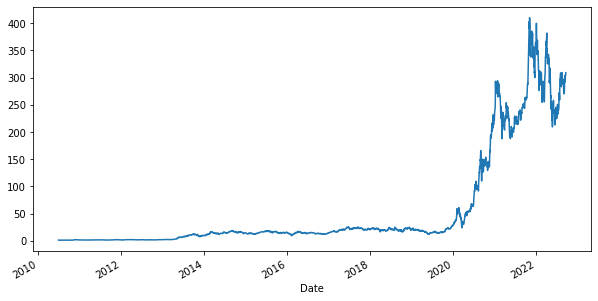

In [7]:
plot_data['Close'].plot(figsize=(10,5)) 

In [8]:
data = data.loc[2600:]

In [9]:
data = data.drop('Date', axis = 1)
data = data.reset_index(drop = True)
data = data.astype('float32')
data.head()

,Close
0,141.559998
1,135.339996
2,136.943329
3,129.346664
4,133.503326


In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data) #scaling the data
data[:10]

array([[0.04352218],
       [0.02135721],
       [0.02707067],
       [0.        ],
       [0.01481226],
       [0.04259568],
       [0.03912717],
       [0.05945098],
       [0.04978204],
       [0.03945976]], dtype=float32)

In [11]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
train_set,test_set = data[:train_size], data[train_size:]

In [12]:
#method to find features for each instances
def features(data, window_size):
    X,Y = [],[]
    for i in range(len(data) - window_size - 1): #for the number of elts of a given data between 0 and the total
                                                 #minus window_size -1 since len is an int not an index
        window = data[i:(i + window_size)]       #the index of elts inside the window
        X.append(window)                         #we append to X the elts whose indexes are inside the window
        Y.append(data[i + window_size])          #and in Y we append the target, i.e the size of the window +
    return np.array(X), np.array(Y)              #i; it returns the arrays of elts and the target.

In [13]:
window_size = 20
X_train, Y_train = features(train_set, window_size)

X_test, Y_test = features(test_set, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [23]:
tf.random.set_seed(11)
np.random.seed(11)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [24]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(units = 50,activation = 'relu', 
                           return_sequences=True, input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [25]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, 
              validation_data = (X_test, Y_test), shuffle = False)

model.summary()

Epoch 1/100
18/18 [==============================] - 1s 20ms/step - loss: 0.1260 - last_time_step_mse: 0.1260 - val_loss: 0.0114 - val_last_time_step_mse: 0.0110
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0388 - last_time_step_mse: 0.0388 - val_loss: 0.0058 - val_last_time_step_mse: 0.0061
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0217 - last_time_step_mse: 0.0217 - val_loss: 0.0058 - val_last_time_step_mse: 0.0056
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0184 - last_time_step_mse: 0.0184 - val_loss: 0.0038 - val_last_time_step_mse: 0.0038
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0184 - last_time_step_mse: 0.0184 - val_loss: 0.0042 - val_last_time_step_mse: 0.0041
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0151 - last_time_step_mse: 0.0151 - val_loss: 0.0043 - val_last_time_step_mse: 0.0042
Epoch 7/100
18/18 [==============

18/18 [==============================] - 0s 4ms/step - loss: 0.0064 - last_time_step_mse: 0.0064 - val_loss: 0.0018 - val_last_time_step_mse: 0.0018
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0069 - last_time_step_mse: 0.0069 - val_loss: 0.0017 - val_last_time_step_mse: 0.0017
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0068 - last_time_step_mse: 0.0068 - val_loss: 0.0018 - val_last_time_step_mse: 0.0017
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0063 - last_time_step_mse: 0.0063 - val_loss: 0.0016 - val_last_time_step_mse: 0.0016
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0069 - last_time_step_mse: 0.0069 - val_loss: 0.0016 - val_last_time_step_mse: 0.0016
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0067 - last_time_step_mse: 0.0067 - val_loss: 0.0016 - val_last_time_step_mse: 0.0016
Epoch 57/100
18/18 [=====================

 gru_2 (GRU)                 (None, 1, 50)             10800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 dense_2 (Dense)             (None, 1, 1)              51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
def plot_loss(train_loss, val_loss, Title, y_max, n_steps):
    x = [i for i in range(0, len(train_loss))] #array of the validation loss
    y= train_loss                            #training loss
    plt.plot(x,y)
    
    x = [i for i in range(0, len(val_loss))] #array of the validation loss
    y= val_loss                              #validation loss
    plt.plot(x,y)                            #plotting validation loss versus training loss
    
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.xticks(x)
    plt.ylim(y_max)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.xlim(xmax=n_steps)
    plt.grid(True)
    ax = plt.gca()
    ax.set_xticks(ax.get_xticks()[::4])
    plt.title(Title)
    plt.show()

In [26]:
history_dict = history.history #model.fit returns a history callback containing the loss for each epoch
print(history_dict.keys())
y_max = max(history.history['loss'])
print(y_max)

dict_keys(['loss', 'last_time_step_mse', 'val_loss', 'val_last_time_step_mse'])
0.12604784965515137


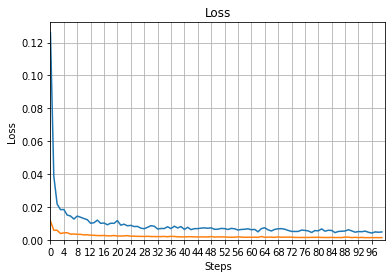

In [27]:
plot_loss(history.history['loss'], history.history['val_loss'], 'Loss', y_max, 100) 
#loss seems on point 

In [28]:
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.0013 - last_time_step_mse: 0.0012


[0.0013267465401440859, 0.0012081890599802136]

In [30]:
len(data)

477

In [32]:
X_new, Y_new = data[:425], data[425:]
Y_pred = model.predict(X_new)

2022-10-05 12:01:55.223564: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 2. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/gru_2/transpose' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 595, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1881, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 508, in dispatch_queue
      await self.process_one()
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 497, in process_one
      await dispatch(*args)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 404, in dispatch_shell
      await result
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 728, in execute_request
      reply_content = await reply_content
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/b8/4rt4232d25lfcbqgf1dykzf80000gn/T/ipykernel_70342/2424451323.py", line 2, in <cell line: 2>
      Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
      return self(x, training=False)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/layers/rnn/base_rnn.py", line 515, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/layers/rnn/gru.py", line 591, in call
      last_output, outputs, states = backend.rnn(
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/backend.py", line 4476, in rnn
      inputs = tf.nest.map_structure(swap_batch_timestep, inputs)
    File "/Users/MacArthur/projects/Coding/machine_learning/master_env/lib/python3.10/site-packages/keras/backend.py", line 4473, in swap_batch_timestep
      return tf.compat.v1.transpose(input_t, axes)
Node: 'sequential_2/gru_2/transpose'
transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node sequential_2/gru_2/transpose}}]] [Op:__inference_predict_function_22471]